# A/B Testing a Marketing Campaign

By Robert Long

## 📊 Introduction

A/B testing is a core technique used in product development and marketing to evaluate whether a new change or intervention improves key user outcomes. In this analysis, we examine data from an A/B test comparing a **control group** to a **variant group**, where the goal is to determine if the variant leads to higher user engagement and revenue.

While we do not have detailed contextual information about the nature of the intervention, we focus on two primary outcome metrics: **revenue per user** and **conversion rate** (whether a user made any purchase). These metrics allow us to assess both the monetary and behavioral impact of the variant.

By analyzing these outcomes using statistical testing and clear visualizations, we aim to determine whether the variant offers a measurable improvement over the control — and whether it should be considered for broader implementation.

---

### Random Assignment

Random assignment was conducted prior to data collection to ensure that users were evenly and fairly distributed between the control and test groups. This process helps eliminate selection bias and allows us to attribute any differences in outcomes—such as conversion rates—directly to the campaign variation, rather than to underlying differences between the groups. Since the assignment was already performed, it is treated as a given in this analysis and does not require implementation in code.

---

Background information about the experiment, such as the specific nature of the intervention or how users were assigned to groups, was not provided in the Kaggle dataset. As a result, the analysis proceeds under the assumption that random assignment and proper experimental controls were in place.


In [ ]:
# import libaries
import warnings
warnings.filterwarnings('ignore')

from google.colab import drive

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import ttest_ind
from statsmodels.stats.proportion import proportions_ztest

In [ ]:
# mount the google drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# import data
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ab-testing/AB_Test_Results.csv')

# check data
df.head()

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0


## Data Aggregation

During preprocessing, we discovered that some `USER_ID`s appeared more than once in the dataset, indicating that certain users returned and generated multiple revenue events. To ensure each user was treated as a single observation, we aggregated the data by summing revenue per user. This transformation aligns with standard A/B testing practices, where the unit of analysis is typically the user. It also preserves the total impact of repeat visits while avoiding bias from treating repeat sessions as independent observations.


In [ ]:
# Count duplicates
duplicate_count = df.duplicated().sum()
print(f"Total duplicate rows: {duplicate_count}")

Total duplicate rows: 2067


In [ ]:
# sum duplicated ids
df_user = df.groupby(['USER_ID', 'VARIANT_NAME'], as_index=False)['REVENUE'].sum()

## Revenue Testing

1. **Objective**
To determine whether the test group (`variant`) generated significantly more revenue per user than the control group.

2. Data Overview


*   `USER_ID`: unique identifier
*   `VARIANT_NAME`: either control or variant
*   `REVENUE`: revenue generated by the user


### Exploratory Data Analysis (EDA)

To begin the analysis, we examined the distribution of revenue across the control and variant groups. Initial summary statistics revealed that revenue was highly skewed, with a large proportion of users generating no revenue at all and a small number of users contributing disproportionately high amounts. For example, the control group had a maximum revenue of 196 while the 75th percentile was still 0 — highlighting the presence of extreme outliers and heavy sparsity.

We attempted to visualize this distribution using box plots, but due to the skew and large concentration of zeros, the box plots were compressed near the bottom of the axis and dominated by outliers. As a result, they failed to communicate meaningful differences between groups.

Instead, we used bar charts to compare the **mean revenue per user** in each group, with error bars representing standard error. This provided a clearer and more interpretable view of average performance while still acknowledging variability.


               count      mean       std  min  25%  50%  75%     max
VARIANT_NAME                                                        
control       3931.0  0.163572  3.385721  0.0  0.0  0.0  0.0  196.01
variant       3934.0  0.089342  1.484566  0.0  0.0  0.0  0.0   58.63




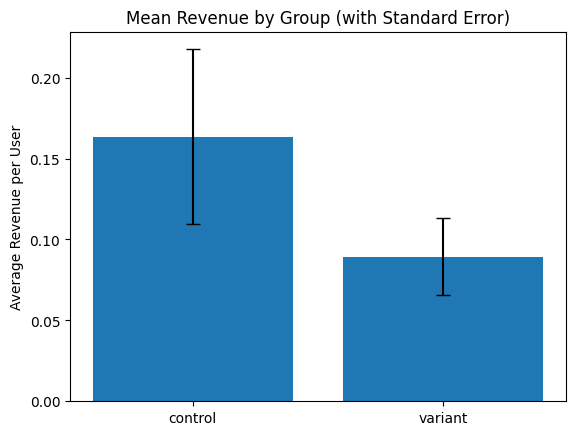

In [ ]:
# Summary statistics
print(df_user.groupby('VARIANT_NAME')['REVENUE'].describe())

# Group means and standard errors
summary = df_user.groupby('VARIANT_NAME')['REVENUE'].agg(['mean', 'sem']).reset_index()

# Prepare manual summary
summary = df_user.groupby('VARIANT_NAME')['REVENUE'].agg(['mean', 'sem'])
x = summary.index
y = summary['mean']
yerr = summary['sem']

print('\n')
# Plot
plt.bar(x, y, yerr=yerr, capsize=5)
plt.ylabel('Average Revenue per User')
plt.title('Mean Revenue by Group (with Standard Error)')
plt.show()

## Statistical Testing

**Approach**

To evaluate whether the difference in mean revenue per user between the control and variant groups was statistically significant, we conducted a **Welch’s t-test**. This test was chosen over the standard Student’s t-test because it does **not assume equal variances** between groups — a key consideration in our case.

As shown in the summary statistics, the control group had a noticeably higher standard deviation in revenue compared to the variant group (3.39 vs. 1.48). Since unequal variances can bias results when using a standard t-test, Welch’s t-test provides a more robust and reliable inference under these conditions.

$$
H_0: \mu_1 = \mu_2
$$

$$
H_A: \mu_1 \ne \mu_2
$$

The result of the Welch’s t-test (T = 1.2590, p = 0.2081) indicates that the observed difference in average revenue is **not statistically significant** at the conventional 0.05 level.

Of course, just looking at the bar chart above, we would know the intervention is not helpful.

---

**Welch’s t-test** is a statistical test used to compare the means of two groups when the assumption of equal variances is not met. Unlike the standard Student’s t-test, Welch’s test does **not assume homogeneity of variance**, making it more robust when the two samples have unequal variances and/or unequal sample sizes.

It still assumes:

* The data in each group are **independent**.
* The data in each group are **approximately normally distributed**.

Fortunately, **Welch’s t-test is quite robust to violations of normality**, especially with larger sample sizes, due to the Central Limit Theorem. This makes it a strong default choice in A/B testing scenarios, particularly when group variances differ.



In [ ]:
# split into two based on control/test
control = df_user[df_user['VARIANT_NAME'] == 'control']['REVENUE']
variant = df_user[df_user['VARIANT_NAME'] == 'variant']['REVENUE']

# calc 2 tail t-test
t_stat, p_val = ttest_ind(control, variant, equal_var=False)
print(f"T-statistic: {t_stat:.4f}, p-value: {p_val:.4f}")

T-statistic: 1.2590, p-value: 0.2081


## Feature Engineering

**Create Conversion Binary**

Minimal feature engineering was required for this analysis. The primary transformation involved creating a binary `converted` variable to indicate whether a user made a purchase. This was derived from the original `revenue` column: any value greater than zero was mapped to `1` (converted), and zero was mapped to `0` (not converted). This binary outcome enables comparison of conversion rates between groups and aligns with standard A/B testing practices.

While this transformation wasn’t strictly necessary, it allows us to evaluate whether the test group was more likely to make a purchase—not just spend more.

In [ ]:
# if revenue > 0, converted
df_user['CONVERTED'] = (df_user['REVENUE'] > 0).astype(int)

## Conversion Analysis

To complement the revenue analysis, we created a binary `CONVERTED` variable to indicate whether a user generated any revenue. This helps assess whether the intervention increased the likelihood of a user making a purchase, regardless of how much they spent.

The conversion rate in the control group was **2.04%**, compared to **1.80%** in the variant group. Although the absolute difference is small, the direction of the effect aligns with the revenue analysis — the **variant consistently underperforms**.

While the difference in conversion rates is not large enough to be practically meaningful, the consistency across both revenue and conversion metrics suggests that the variant does not provide any improvement and may in fact slightly reduce user engagement or purchasing behavior.


In [ ]:
# summary stats
conversion_summary = df_user.groupby('VARIANT_NAME')['CONVERTED'].agg(['count', 'sum', 'mean'])
conversion_summary.rename(columns={'sum': 'Total Conversions', 'mean': 'Conversion Rate'}, inplace=True)
print(conversion_summary)

              count  Total Conversions  Conversion Rate
VARIANT_NAME                                           
control        3931                 80         0.020351
variant        3934                 71         0.018048


### Conversion Rate Significance Test Results

To test whether the difference in conversion rates between the control and variant groups was statistically significant, we conducted a **two-proportion z-test**. This test is appropriate for comparing proportions when the sample sizes are large and binary outcomes are involved.

$$
H_0: p_1 = p_2
$$

$$
H_A:p_1 \ne p_2
$$

The result was:

* **Z-statistic**: 0.7443
* **P-value**: 0.4567

Since the p-value is well above the standard threshold of 0.05, we **fail to reject the null hypothesis**. This means there is **no statistically significant difference in conversion rates** between the two groups. The observed difference — 2.04% in the control group vs. 1.80% in the variant — is small and likely due to random variation.

Combined with the revenue analysis, this result further suggests that the variant does not provide a measurable improvement and may in fact be slightly worse in terms of both engagement and monetary outcome.

---

**Z-tests** are used to compare proportions or means when certain assumptions are met. In A/B testing, they’re commonly used to compare **conversion rates** between two groups.

Key assumptions:

* The data are **independent and randomly sampled**.
* The **sampling distribution of the proportion is approximately normal** — typically valid when both $n \cdot p$ and $n \cdot (1 - p)$ are ≥ 5 for each group (i.e., sufficient sample size).
* The test uses the **pooled proportion** under the null hypothesis when comparing two proportions.

Z-tests are less robust to violations of these assumptions than t-tests. However, with large enough samples, they perform well due to the **Central Limit Theorem**, making them appropriate for large-scale A/B tests on binary outcomes like conversions.


In [ ]:
# Successes
successes = [80, 71]

# Observations (sample sizes)
n = [3931, 3934]

# Two-sided z test
z_stat, p_val = proportions_ztest(successes, n)
print(f"Z-statistic: {z_stat:.4f}, p-value: {p_val:.4f}")


Z-statistic: 0.7443, p-value: 0.4567


## Conclusion and Business Insights

Based on our A/B test analysis, there is no evidence that the tested variant improves user outcomes. Both revenue and conversion metrics slightly favored the control group, but the differences were **not statistically significant**. Specifically:

* Mean revenue per user was higher in the control group, but **Welch’s t-test (p = 0.2081)** indicated no significant difference.
* Conversion rates were also marginally higher in the control group (2.04% vs. 1.80%), but the **z-test for proportions (p = 0.4567)** confirmed that this difference was not statistically significant.

Given these results, we conclude that the variant **does not provide a measurable improvement** in either engagement or monetary value. Without further research, testing, or refinement of the intervention, there is **no business justification** for rolling it out more broadly. If this was intended as a product or marketing change, it may be more prudent to either redesign the intervention or explore other avenues for increasing user value. We need more information from stakeholders on what this data represents.

---

Effect size was not a focus in this analysis, as the results showed no statistically or practically meaningful difference between groups. While it’s common to highlight large or significant effects, finding no effect is itself valuable—indicating that the current intervention is unlikely to drive meaningful change and may warrant redesign or further testing before implementation.
